In [150]:
import numpy as np
exp = np.exp
arange = np.arange
ln = np.log
from datetime import *

import matplotlib.pyplot as plt
from matplotlib import patches

from scipy.stats import norm
from scipy import interpolate as interp
pdf = norm.pdf
cdf = norm.cdf
ppf = norm.ppf

from scipy import stats
from scipy import special
erf = special.erf

import pandas as pd
import seaborn as sns
cp = sns.color_palette()

from lifelines import KaplanMeierFitter
from sklearn.metrics import brier_score_loss
from sklearn.linear_model import LogisticRegression
from sklearn import mixture
from sklearn import preprocessing

In [151]:
lc_df = pd.read_csv('lc_data.csv')
nsclc = pd.read_csv('nsclc_data.csv')
nsclc_subset = pd.read_csv('nsclc_data_subset.csv')

## kde / cdf functions

In [152]:
def create_kde(array, bandwidth=None):
    """ calculating KDE and CDF using scipy """
    if bandwidth == None:
        bw = 'scott'
    else:
        bw = bandwidth
    kde = stats.gaussian_kde(dataset=array,bw_method=bw)
    
    num_test_points=200
    x = np.linspace(0,np.max(array)*1.2,num_test_points)
    kdens=kde.pdf(x)
    
    cdf=np.zeros(shape=num_test_points)
    for i in range(num_test_points):
        cdf[i] = kde.integrate_box_1d(low=0,high=x[i])
        
    return x,kdens,cdf


def calc_cdf(array,var,bandwidth=None):
    if bandwidth == None:
        bw = 1.2*array.std()*np.power(array.size,-1/5)
    else:
        bw = bandwidth
    kde=stats.gaussian_kde(dataset=array,bw_method=bw)
    return kde.integrate_box_1d(low=0,high=var)




## Distribution, GM analysis

In [153]:
from scipy.stats import energy_distance

In [177]:
r1=lc_df["rsi"].values
r2= nsclc["rsi"].values
r3 = nsclc_subset["rsi"].values

In [178]:
from scipy.stats import ks_2samp

In [179]:
energy_distance(r1,r2)

0.12287340659761281

In [180]:
energy_distance(r1,r3)

0.16408719480556738

In [181]:
energy_distance(r2,r3)

0.043776889643486985

In [182]:
r1=r1.reshape(-1,1)
r2=r2.reshape(-1,1)
r3=r3.reshape(-1,1)

In [183]:
gm1 = mixture.GaussianMixture(n_components=2)#,covariance_type='full')

gm1.fit(X=r1)

m1 = gm1.means_.ravel()
se1, wt1 = [np.sqrt(gm1.covariances_).ravel(), gm1.weights_.ravel()]

m1, se1


(array([0.29574993, 0.47393263]), array([0.08914681, 0.01603881]))

In [184]:
gm2 = mixture.GaussianMixture(n_components=2,covariance_type='full')

gm2.fit(X=r2)

m2 = gm2.means_.ravel()

se2, wt2 = [np.sqrt(gm2.covariances_).ravel(), gm2.weights_.ravel()]

m2, se2

(array([0.29826448, 0.47065336]), array([0.05571924, 0.06118052]))

In [185]:
gm3 = mixture.GaussianMixture(n_components=2,covariance_type='full')

gm3.fit(X=r3)

m3 = gm3.means_.ravel()

se3, wt3 = [np.sqrt(gm3.covariances_).ravel(), gm3.weights_.ravel()]

m3, se3

(array([0.28680238, 0.46306156]), array([0.04264092, 0.07964801]))

In [188]:
colrs = [(.9,.35,.2), (.1, .7, .7)]

[]

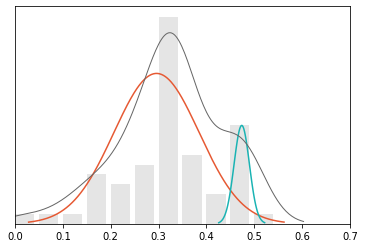

In [189]:
fig, ax = plt.subplots()

for i in range(2):
    xi = np.arange(m1[i]-3*se1[i], m1[i]+3*se1[i], .001)
    yi = norm.pdf(xi,m1[i],se1[i])*wt1[i]**1.3

    ax.plot(xi,yi, color = colrs[i])

kde1 = create_kde(r1.ravel())
ax.plot(kde1[0], kde1[1]*1.1, color = (.4,.4,.4),lw=1)

hist1 = np.histogram(r1,bins=np.arange(0,.8,.05),density=True,)
ax.bar(x=hist1[1][0:-1], height = hist1[0]*.7, width=.04, align = 'edge', alpha = .2, color=(.5,.5,.5))

ax.set_xlim(0,.7)
ax.set_yticks([])


[]

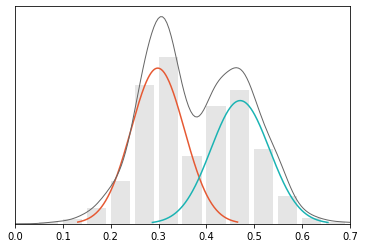

In [190]:
fig, ax = plt.subplots()

for i in range(2):
    xi = np.arange(m2[i]-3*se2[i], m2[i]+3*se2[i], .001)
    yi = norm.pdf(xi,m2[i],se2[i])*wt2[i]**1.3

    ax.plot(xi,yi,color = colrs[i])

kde2 = create_kde(r2.ravel())
ax.plot(kde2[0], kde2[1], color = (.4,.4,.4),lw=1)

hist2 = np.histogram(r2,bins=np.arange(0,.8,.05),density=True,)
ax.bar(x=hist2[1][0:-1], height = hist2[0]*.8, width=.04, align = 'edge', alpha = .2, color = (.5,.5,.5))

ax.set_xlim(0,.7)
ax.set_yticks([])


[]

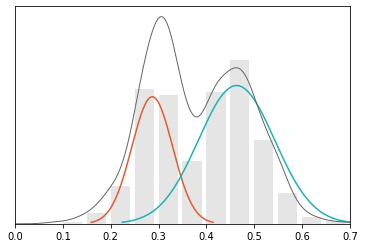

In [191]:
fig, ax = plt.subplots()

for i in range(2):
    xi = np.arange(m3[i]-3*se3[i], m3[i]+3*se3[i], .001)
    yi = norm.pdf(xi,m3[i],se3[i])*wt3[i]**1.3

    ax.plot(xi,yi,color = colrs[i])

kde3 = create_kde(r3.ravel())
ax.plot(kde2[0], kde2[1], color = (.4,.4,.4),lw=1)

hist3 = np.histogram(r3,bins=np.arange(0,.8,.05),density=True,)
ax.bar(x=hist3[1][0:-1], height = hist3[0]*.8, width=.04, align = 'edge', alpha = .2, color = (.5,.5,.5))

ax.set_xlim(0,.7)
ax.set_yticks([])


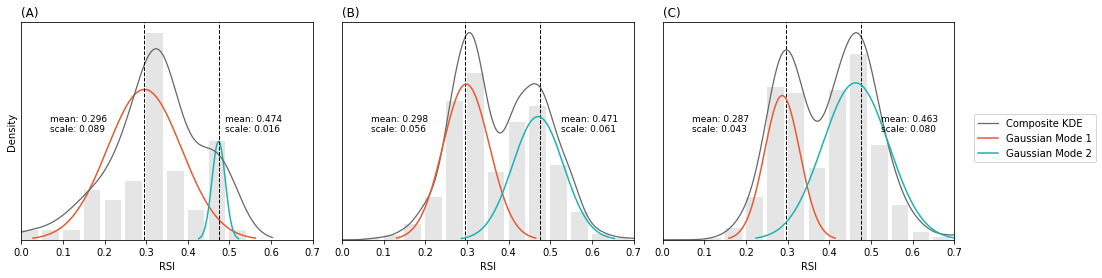

In [195]:
fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(16,4))

""" --------- first subplot ------------- """
colrs = [(.9,.35,.2), (.1, .7, .7)]

ax = axes[0]
for i in range(2):
    xi = np.arange(m1[i]-3*se1[i], m1[i]+3*se1[i], .001)
    yi = norm.pdf(xi,m1[i],se1[i])*wt1[i]**1.3

    ax.plot(xi,yi, color = colrs[i])

kde1 = create_kde(r1.ravel())
ax.plot(kde1[0], kde1[1]*1.1, color = (.4,.4,.4),lw=1.25)

hist1 = np.histogram(r1,bins=np.arange(0,.8,.05),density=True,)
ax.bar(x=hist1[1][0:-1], height = hist1[0]*.7, width=.04, align = 'edge', alpha = .2, color=(.5,.5,.5))

ax.axvline(x=.295, ls='--', color='k', lw=1)
ax.axvline(x=.475, ls='--', color='k', lw=1)

string_text = "mean: %.3f\nscale: %.3f" % (m1[0], se1[0])
ax.text(x=.1, y= .5, s = string_text, transform = ax.transAxes, fontsize=9)
string_text = "mean: %.3f\nscale: %.3f" % (m1[1], se1[1])
ax.text(x=.7, y= .5, s = string_text, transform = ax.transAxes, fontsize=9)

ax.set_xlim(0,.7)
ax.set_yticks([])
ax.set_ylabel("Density")
ax.set_title("(A)",loc = 'left')
ax.set_xlabel("RSI")

""" --------- second subplot ------------- """

colrs = [(.9,.35,.2), (.1, .7, .7)]


ax = axes[1]

kde2 = create_kde(r2.ravel())
ax.plot(kde2[0], kde2[1], color = (.4,.4,.4),lw=1.25, label='Composite KDE')

hist2 = np.histogram(r2,bins=np.arange(0,.8,.05),density=True,)
ax.bar(x=hist2[1][0:-1], height = hist2[0]*.8, width=.04, align = 'edge', alpha = .2, color = (.5,.5,.5))

ax.axvline(x=.295, ls='--', color='k', lw=1)
ax.axvline(x=.475, ls='--', color='k', lw=1)

labels = ["Gaussian Mode 1", "Gaussian Mode 2"]
for i in range(2):
    xi = np.arange(m2[i]-3*se2[i], m2[i]+3*se2[i], .001)
    yi = norm.pdf(xi,m2[i],se2[i])*wt2[i]**1.3

    ax.plot(xi,yi,color = colrs[i], label = labels[i])

string_text = "mean: %.3f\nscale: %.3f" % (m2[0], se2[0])
ax.text(x=.1, y= .5, s = string_text, transform = ax.transAxes,fontsize=9)
string_text = "mean: %.3f\nscale: %.3f" % (m2[1], se2[1])
ax.text(x=.75, y= .5, s = string_text, transform = ax.transAxes,fontsize=9)

ax.set_xlim(0,.7)
ax.set_yticks([])
ax.set_title("(B)", loc = 'left')
ax.set_xlabel("RSI")

""" --------- third subplot ------------- """

ax = axes[2]

kde3 = create_kde(r3.ravel())
ax.plot(kde3[0], kde3[1], color = (.4,.4,.4),lw=1.25, label='Composite KDE')

hist3 = np.histogram(r3,bins=np.arange(0,.8,.05),density=True,)
ax.bar(x=hist3[1][0:-1], height = hist3[0]*.8, width=.04, align = 'edge', alpha = .2, color = (.5,.5,.5))

ax.axvline(x=.295, ls='--', color='k', lw=1)
ax.axvline(x=.475, ls='--', color='k', lw=1)

labels = ["Gaussian Mode 1", "Gaussian Mode 2"]
for i in range(2):
    xi = np.arange(m3[i]-3*se3[i], m3[i]+3*se3[i], .001)
    yi = norm.pdf(xi,m3[i],se3[i])*wt3[i]**1.3

    ax.plot(xi,yi,color = colrs[i], label = labels[i])

string_text = "mean: %.3f\nscale: %.3f" % (m3[0], se3[0])
ax.text(x=.1, y= .5, s = string_text, transform = ax.transAxes,fontsize=9)
string_text = "mean: %.3f\nscale: %.3f" % (m3[1], se3[1])
ax.text(x=.75, y= .5, s = string_text, transform = ax.transAxes,fontsize=9)

ax.set_xlim(0,.7)
ax.set_yticks([])
ax.set_title("(C)", loc = 'left')
ax.set_xlabel("RSI")


ax.legend(bbox_to_anchor = (1.05,0.6))

fig.subplots_adjust(wspace=.1,left=.04, right= .85)

plt.savefig('/Users/jessicascarborough/repos/nsclc-model/Supplemental/Figures/'+'dist_comparison', dpi =300) #, edgecolor='black', linewidth=4)

Checking the KS statistic between the KDE distributions: 

In [193]:
ks_2samp(data1 = kde1[0], data2 = kde2[0])

Ks_2sampResult(statistic=0.33, pvalue=4.869254633582969e-10)

In [47]:
ks_2samp(data1 = kde1[0], data2 = kde3[0])

Ks_2sampResult(statistic=0.405, pvalue=4.734741877153768e-15)

In [48]:
ks_2samp(data1 = kde2[0], data2 = kde3[0])

Ks_2sampResult(statistic=0.11, pvalue=0.17793352788293415)

## NTCP adjustments:

In [7]:
def prob_pneumonitis(dose_h, dose_l = 0):
    fx_to_lung = 8.5
    MLDh = dose_h/fx_to_lung
    MLDl = dose_l/fx_to_lung
    b0 = -3.87
    b1 = 0.126
    prob_h = np.exp(b0+b1*MLDh)/(1+np.exp(b0+b1*MLDh))
    if np.all(dose_l==0):
        prob_l = np.exp(b0+b1*MLDl)/(1+np.exp(b0+b1*MLDl))
    else:
        prob_l = np.zeros(dose_l.size)
    return prob_h, prob_l

def pneumonitis_RR(dose_h, dose_l = 0):
    prob_h, prob_l = prob_pneumonitis(dose_h,dose_l)
    rr = (1+prob_h)/(1+prob_l)
    return np.round(rr,3)

def prob_esoph(dose_h, dose_l = 0):
    EUD1 = dose_h/4
    EUD2 = dose_l/4
    TD50 = 47
    m = 0.36
    t1 = (EUD1-TD50)/(m*TD50)
    t2 = (EUD2-TD50)/(m*TD50)
    y = (erf(t1)-erf(t2))/2
    return np.round(y,3)

def esophagitis_RR(dose_h, dose_l = 0):
    
    prob_h = prob_esoph(dose_h)
    prob_l = prob_esoph(dose_l)
    rr = (1+prob_h)/(1+prob_l)
    return np.round(rr,4)

def cardiac_event_RR(dose_h, dose_l = 0):
    
    dose_diff = dose_h-dose_l
    delta_dose_heart = np.mean((dose_h-dose_l)/14)
    risk_per_gy = np.zeros(len(t))
    risk_per_gy = np.where(t<5,16.3,0)
    risk_per_gy = np.where(5<=t,15.5,risk_per_gy)
    risk_per_gy = np.where(t>=10,1.2,risk_per_gy)
    #risk_per_gy = 7.4    #  percent increased risk
    cardiac_event_rr = 1+risk_per_gy*delta_dose_heart/100
#     cardiac_event_rr = 1+.074*delta_dose_heart
    
    return cardiac_event_rr


In [8]:
def H_esoph2(dose, CI=None):
    TD50 = 47
    TD50l=60
    TD50u=41
    m = 0.36
    mu = 0.55
    ml = 0.25
    if CI == 'upper':
        TD50 = TD50u
        scale = mu*TD50u/np.sqrt(2)
    elif CI == 'lower':
        TD50 = TD50l
        scale = ml*TD50l/np.sqrt(2)
    else:
        scale = m*TD50/np.sqrt(2)
    y=norm.cdf(dose/4,TD50,scale)
    return y


def H_lung(dose_h, dose_l = 0, CI = None):
    fx_to_lung = 1/8.5
    MLD = dose_h*fx_to_lung
    b0 = -3.87
    b0u = -3.33
    b0l =  -4.49
    
    b1 = 0.126
    b1u = .153
    b1l = .100
    
    if CI==None:
        prob_h = np.exp(b0+b1*MLD)/(1+np.exp(b0+b1*MLD))
        constant = np.exp(b0)/(1+np.exp(b0))
    # TD50 = 30.75 [28.7–33.9] Gy
    if CI == 'upper':
        b0 = b0u
        b1 = b1u
        prob_h = np.exp(b0+b1*MLD)/(1+np.exp(b0+b1*MLD))
        constant = np.exp(b0)/(1+np.exp(b0))
    elif CI == 'lower':
        b0 = b0l
        b1 = b1l
        prob_h = np.exp(b0+b1*MLD)/(1+np.exp(b0+b1*MLD))
        constant = np.exp(b0)/(1+np.exp(b0))
    
    prob = prob_h - constant
        
    return prob

In [9]:
def risk_p(dose,CI=None):
    r = H_lung(dose,CI)
    return r
def risk_e(dose,CI=None):
    r = H_esoph2(dose,CI)
    return r

def rr_card(dose, CI = None):
    if CI==None:
        rr = 1 + dose/14*.074
    elif CI == 'upper':
        rr = 1 + dose/14*.145
    elif CI == 'lower':
        rr = 1 + dose/14*.029
    return rr

## fig 4

### tcc hist with percentages (first panel)

Text(0.5, 0, 'RxRSI for TCC Lung')

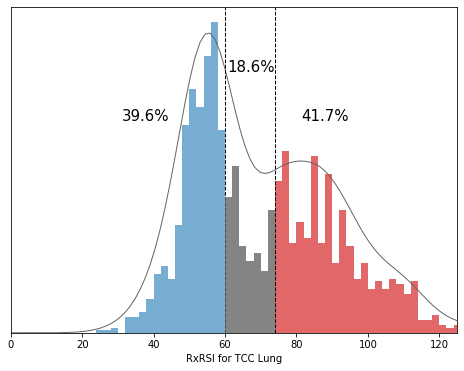

In [10]:
r = nsclc.rsi

d = 2
beta = 0.05

# for SF2 alpha
n = 1
alpha_tcc = np.log(r)/(-n*d) - beta*d
rxdose_tcc = 33/(alpha_tcc+beta*d)
rxdose_tcc=rxdose_tcc.values

""" plotting histograms """
fig, ax = plt.subplots(figsize=(8,6))
binlist=list(np.arange(0,150,2))+[300]

""" <60 range """
xdata = rxdose_tcc[np.where(rxdose_tcc<60)]
wts =  np.full(len(xdata),.0002)
ax.hist(xdata,bins = binlist,
        alpha=.6,#ec = 'k',
        color=cp[0],  
        weights = wts)

""" 60-74 range """
xdata = rxdose_tcc[np.where((rxdose_tcc>60)&(rxdose_tcc<74))]
wts =  np.full(len(xdata),.0002)
ax.hist(xdata,bins = binlist,
        alpha=.8,#ec = 'k',
        color=(.4,.4,.4),  
        weights = wts,zorder=5)

""" >74 range """
xdata = rxdose_tcc[np.where((rxdose_tcc>74))]  #&(rxdose_tcc<80))]
wts =  np.full(len(xdata),.0002)
ax.hist(xdata,bins = binlist,
        alpha=.7,#ec = 'k',
        color=cp[3],  
        weights = wts)

rxdose_kde = create_kde(rxdose_tcc,bandwidth=.15)

pp_60 = np.where(rxdose_kde[0]<=60,rxdose_kde[2],0).max()
pp_74 = np.where(rxdose_kde[0]<=74,rxdose_kde[2],0).max()
pp_60_74 = pp_74 - pp_60
pp_over_74 = 1 - pp_74

rxdose_kde = create_kde(rxdose_tcc,bandwidth=.26)
ax.plot(rxdose_kde[0], rxdose_kde[1] , c=(.4,.4,.4),lw=1,ls='-',label = 'KDE')

ax.text(.25,.65,'{:0.1f}%'.format(pp_60*100), transform=ax.transAxes, fontsize=15)
ax.text(.485,.8,'{:0.1f}%'.format(pp_60_74*100), transform=ax.transAxes,fontsize=15)
ax.text(.65,.65,'{:0.1f}%'.format(pp_over_74*100), transform=ax.transAxes,fontsize=15)

ax.axvline(x = 60,c='k',lw=1,ls='--')
ax.axvline(x = 74,c='k',lw=1,ls='--')


ax.set_xlim(0,125)
ax.set_yticks([])
ax.set_xlabel('RxRSI for TCC Lung')


## 60 pt group outcome analysis

In [11]:
from lifelines import KaplanMeierFitter
from lifelines import WeibullFitter
from lifelines import CoxPHFitter
from lifelines.statistics import logrank_test

### km fits

In [12]:
T = lc_df['td_yrs'].values
E = lc_df['LocalFailure'].values

idx = lc_df.gardtx>=33
T1 = T[idx]
T2 = T[~idx]
E1 = E[idx]
E2 = E[~idx]

km1 = KaplanMeierFitter()
km1.fit(T1, event_observed = E1, label = 'KM GARD>33')
km2 = KaplanMeierFitter()
km2.fit(T2, event_observed = E2, label = 'KM GARD<33')
km_all = KaplanMeierFitter()
km_all.fit(T, event_observed = E, label = 'KM All')


<lifelines.KaplanMeierFitter:"KM All", fitted with 60 total observations, 37 right-censored observations>

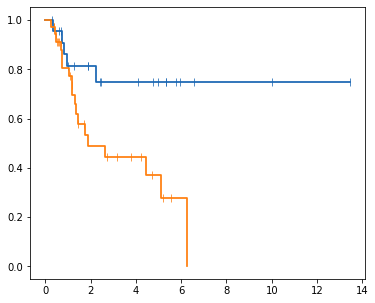

In [13]:
survtable1 = km1.survival_function_
S_km1 = survtable1.values
t_1 = survtable1.index.values

survtable2 = km2.survival_function_
S_km2 = survtable2.values
t_2 = survtable2.index.values

t1_cens = T1[np.where(E1!=1)]
C1 = survtable1.loc[t1_cens]
t2_cens = T2[np.where(E2!=1)]
C2 = survtable2.loc[t2_cens]

fig,ax = plt.subplots(figsize=(6,5))

col = (.1,.4,.7)
ax.step(t_1,S_km1,where = 'post',color=col,lw=1.75)
ax.scatter(t1_cens,C1,marker='|',color=col,s=50,lw=.75)

col  = cp[1]
ax.step(t_2,S_km2,where = 'post',color=col,lw=1.75)
ax.scatter(t2_cens,C2,marker='|',color=col,s=50,lw=.75)


In [14]:

T = lc_df['td_yrs']
E = lc_df['LocalFailure']
gard=lc_df['gardtx']
idx = gard>33

T1 = T[idx]
T2 = T[~idx]
E1 = E[idx]
E2 = E[~idx]

wf0 = WeibullFitter()
wf0.fit(T,E)
wf1 = WeibullFitter()
wf1.fit(T1, E1)
wf2 = WeibullFitter()
wf2.fit(T2, E2)

def S1(t):
    return wf1.predict(t)
def S2(t):
    return wf2.predict(t)

pd.concat([wf1.summary, wf2.summary, wf0.summary],axis=0)

,coef,se(coef),coef lower 95%,coef upper 95%,z,p,-log2(p)
lambda_,34.593204,37.662685,-39.224302,108.410710,0.891949,0.372420,1.424997
rho_,0.641806,0.249403,0.152985,1.130628,-1.436201,0.150945,2.727904
lambda_,3.800639,0.785632,2.260828,5.340450,3.564821,0.000364,11.423358
rho_,1.161700,0.211019,0.748111,1.575289,0.766283,0.443508,1.172969
lambda_,7.233135,1.882663,3.543184,10.923086,3.310808,0.000930,10.070065
rho_,0.893703,0.148328,0.602986,1.184420,-0.716636,0.473599,1.078263


### wbl fit for gard 33 cutpoint

In [15]:
def S1(t):
    lambda_ = 0.028907
    rho_ = 0.641806
    y = np.exp(-1*np.power(lambda_*t,rho_))
    return y

def S2(t):
    lambda_ = 0.263115
    rho_ = 1.161710
    y = np.exp(-1*np.power(lambda_*t,rho_))
    return y

In [16]:
def plc(lc, dose, CI=None):
    plc = np.power(lc,np.exp(risk_p(dose,CI) + risk_e(dose,CI))*rr_card(dose,CI))
    return plc

### trials of escalation (panels 2 & 3)

In [30]:

def calc_rxdose(rsi_array):
    d = 2
    beta = 0.05
    n = 1
    alpha_array = np.log(rsi_array)/(-n*d) - beta*d
    rxdose_array = 33/(alpha_array+beta*d)
    return rxdose_array

def percentile(array,val):
    pp = np.argwhere(array<=val).size/array.size
    return pp

""""------------------------------------------------"""

trials = 1000
num_pts = 400
t=np.arange(0,10,.1)

rsi_cohort = np.zeros(num_pts)
rxdose = np.zeros(num_pts)

results_1 = np.zeros(shape=(trials,len(t)))
results_2 = np.zeros(shape=(trials,len(t)))
results_3 = np.zeros(shape=(trials,len(t)))

dose_array = np.zeros(shape=(trials,3))

for i in range(trials):
#     rsi_cohort = np.random.choice(r,num_pts)
    
    cohort_1_rxdose = calc_rxdose(np.random.choice(r,num_pts))    # 60 Gy arm
    cohort_2_rxdose = calc_rxdose(np.random.choice(r,num_pts))    # selective escalation

    """case 1: 60 vs. selected escalation to 74"""

    C1 = percentile(cohort_1_rxdose,60)
    C2 = 1 - C1
    lc_cohort_1 = C1*S1(t) + C2*S2(t)
    C1 = percentile(cohort_2_rxdose,74)
    C2 = 1 - C1
    lc_cohort_2 = C1*S1(t) + C2*S2(t)

    dose_array[i,0] = 60
    dose_cohort_2 = np.where((cohort_2_rxdose>60) & (cohort_2_rxdose<=74), 74, 60)
    dose_array[i,1] = np.mean(dose_cohort_2)
    results_1[i,:] = lc_cohort_1
    results_2[i,:] = lc_cohort_2

    """case 2: 60 vs. 45-80"""
    cohort_3_rxdose = calc_rxdose(np.random.choice(r,num_pts))    # precision dosing

    C1 = percentile(cohort_3_rxdose,80)
    C2 = 1 - C1
    lc_cohort_3 = C1*S1(t) + C2*S2(t)

    dose_cohort_3 = np.where((cohort_3_rxdose>=45) & (cohort_3_rxdose<=80), cohort_3_rxdose, 60)
    dose_array[i,2] = np.mean(dose_cohort_3)
    results_3[i,:] = lc_cohort_3

# average and std deviation for lc results all trials
lc1_ave = np.average(results_1, axis=0)
lc2_ave = np.average(results_2, axis=0)
lc3_ave = np.average(results_3, axis=0)
lc1_SE = np.std(results_1,axis=0)
lc2_SE = np.std(results_2,axis=0)
lc3_SE = np.std(results_3,axis=0)


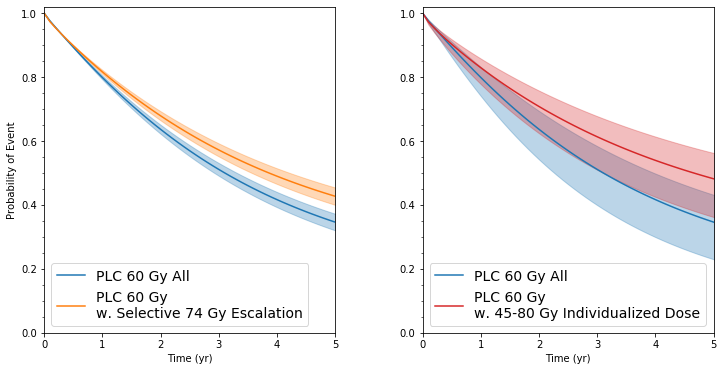

In [31]:
fig,axes = plt.subplots(nrows=1,ncols=2,figsize = (12,6),sharex=False)
    
"""------- first panel ---------"""
ax = axes[0]

plc1 = plc(lc1_ave,60)
ax.plot(t,plc1, label='PLC 60 Gy All')
# upper1 = plc(lc1_ave + 2*lc1_SE,60,'lower')
# lower1 = plc(lc1_ave - 2*lc1_SE,60,'upper')
upper1 = plc(lc1_ave + 2*lc1_SE,60)
lower1 = plc(lc1_ave - 2*lc1_SE,60)
ax.fill_between(t,upper1,lower1,color=cp[0],alpha=.3)


# ax.plot(t,plc_cohort_2_ave, label='PLC 60 Gy \nw. Selective 74 Gy Escalation')
dose = np.mean(dose_array[:,1],axis=0)
plc2 = plc(lc2_ave,dose)
ax.plot(t,plc2, label='PLC 60 Gy \nw. Selective 74 Gy Escalation', color=cp[1])
# upper2 = plc(lc2_ave + 2*lc2_SE,dose,'lower')
# lower2 = plc(lc2_ave - 2*lc2_SE,dose,'upper')
upper2 = plc(lc2_ave + 2*lc2_SE,dose)
lower2 = plc(lc2_ave - 2*lc2_SE,dose)
ax.fill_between(t,upper2,lower2,color=cp[1],alpha=.3)


"""-------- second panel -----------"""
ax = axes[1]

plc1 = plc(lc1_ave,60)
ax.plot(t,plc1, label='PLC 60 Gy All')
upper1 = plc(lc1_ave + 2*lc1_SE,60,'lower')
lower1 = plc(lc1_ave - 2*lc1_SE,60,'upper')
ax.fill_between(t,upper1,lower1,color=cp[0],alpha=.3)

dose = np.mean(dose_array[:,2],axis=0)
plc3 = plc(lc3_ave,dose)
ax.plot(t,plc3,  label='PLC 60 Gy \nw. 45-80 Gy Individualized Dose', color=cp[3])
upper3 = plc(lc3_ave + 2*lc3_SE,dose,'lower')
lower3 = plc(lc3_ave - 2*lc3_SE,dose,'upper')
ax.fill_between(t,upper3,lower3,color=cp[3],alpha=.3)

for i in range(axes.size):
    ax=axes[i]    
    ax.set_yticks(np.arange(0,1.2,.2),minor=False)

    ax.set_xticks(range(6))
    ax.set_xticklabels(list('012345'))
    ax.set_xlabel('Time (yr)')
    if i == 0: ax.set_ylabel('Probability of Event')
    ax.set_yticks(np.arange(0,1,.05),minor=True)
    ax.set_xbound(0,5)
    ax.set_ylim(0,1.02)
    ax.legend(fontsize=14)


fig.subplots_adjust(wspace=.3)


calculating percentages at 2 and 5 years

In [22]:
for i in [20,50]:
    z=plc1[i]*100
    y=plc2[i]*100
    print('{}\n'.format(y-z))


4.228059853227315

8.09049367510898



In [23]:
for i in [20,50]:
    z=plc1[i]*100
    y=plc3[i]*100
    print('{}\n'.format(y-z))


7.173679431669363

13.647356020113925



### combined 3 panel for fig #4

/Users/geoffreysedor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:124: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/Users/geoffreysedor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:125: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


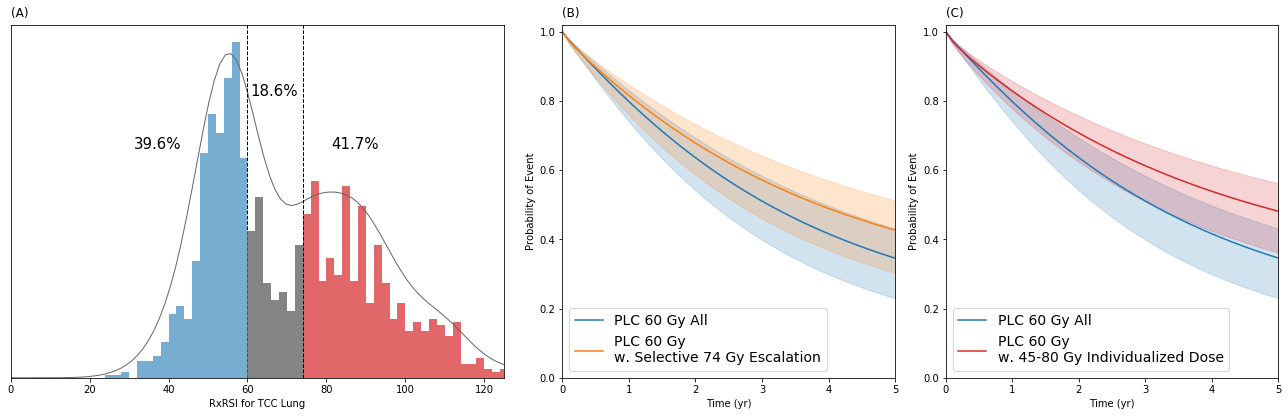

In [46]:
from matplotlib.gridspec import GridSpec

r = nsclc.rsi
d = 2
beta = 0.05
n = 1
alpha_tcc = np.log(r)/(-n*d) - beta*d
rxdose_tcc = 33/(alpha_tcc+beta*d)
rxdose_tcc=rxdose_tcc.values

fig = plt.figure(figsize=(18,6))
gs1 = GridSpec(1, 1, figure=fig)
gs2 = GridSpec(1, 2, figure=fig)

""" ------------------plotting histogram--------------- """
ax = fig.add_subplot(gs1[0,0])

binlist=list(np.arange(0,150,2))+[300]

""" <60 range """
xdata = rxdose_tcc[np.where(rxdose_tcc<60)]
wts =  np.full(len(xdata),.0002)
ax.hist(xdata,bins = binlist,
        alpha=.6,#ec = 'k',
        color=cp[0],  
        weights = wts)

""" 60-74 range """
xdata = rxdose_tcc[np.where((rxdose_tcc>60)&(rxdose_tcc<74))]
wts =  np.full(len(xdata),.0002)
ax.hist(xdata,bins = binlist,
        alpha=.8,#ec = 'k',
        color=(.4,.4,.4),  
        weights = wts,zorder=5)

""" >74 range """
xdata = rxdose_tcc[np.where((rxdose_tcc>74))]  #&(rxdose_tcc<80))]
wts =  np.full(len(xdata),.0002)
ax.hist(xdata,bins = binlist,
        alpha=.7,#ec = 'k',
        color=cp[3],  
        weights = wts)

rxdose_kde = create_kde(rxdose_tcc,bandwidth=.15)

pp_60 = np.where(rxdose_kde[0]<=60,rxdose_kde[2],0).max()
pp_74 = np.where(rxdose_kde[0]<=74,rxdose_kde[2],0).max()
pp_60_74 = pp_74 - pp_60
pp_over_74 = 1 - pp_74

rxdose_kde = create_kde(rxdose_tcc,bandwidth=.26)
ax.plot(rxdose_kde[0], rxdose_kde[1] , c=(.4,.4,.4),lw=1,ls='-',label = 'KDE')

ax.text(.25,.65,'{:0.1f}%'.format(pp_60*100), transform=ax.transAxes, fontsize=15)
ax.text(.485,.8,'{:0.1f}%'.format(pp_60_74*100), transform=ax.transAxes,fontsize=15)
ax.text(.65,.65,'{:0.1f}%'.format(pp_over_74*100), transform=ax.transAxes,fontsize=15)

ax.axvline(x = 60,c='k',lw=1,ls='--')
ax.axvline(x = 74,c='k',lw=1,ls='--')

ax.set_xlim(0,125)
ax.set_yticks([])
ax.set_xlabel('RxRSI for TCC Lung')
ax.set_title('(A)',loc='left',pad=8)

    
"""------- second panel ---------"""
# ax = axes[1]
ax = fig.add_subplot(gs2[0,0])

plc1 = plc(lc1_ave,60)
ax.plot(t,plc1, label='PLC 60 Gy All')
upper1 = plc(lc1_ave+2*lc1_SE,60,'lower')
lower1 = plc(lc1_ave-2*lc1_SE,60,'upper')
ax.fill_between(t,upper1,lower1,color=cp[0],alpha=.2)

dose = np.mean(dose_array[:,1],axis=0)
plc2 = plc(lc2_ave,dose)
ax.plot(t,plc2, label='PLC 60 Gy \nw. Selective 74 Gy Escalation', color=cp[1])
upper2 = plc(lc2_ave+2*lc2_SE,dose,'lower')
lower2 = plc(lc2_ave-2*lc2_SE,dose,'upper')
ax.fill_between(t,upper2,lower2,color=cp[1],alpha=.2)

ax.set_yticks(np.arange(0,1.2,.2),minor=False)
ax.set_xticks(range(6))
ax.set_xticklabels(list('012345'))
ax.set_xlabel('Time (yr)')
ax.set_ylabel('Probability of Event')
ax.set_xbound(0,5)
ax.set_ylim(0,1.02)
ax.legend(fontsize=14, loc=3)
ax.set_title('(B)',loc='left',pad=8)

"""-------- third panel -----------"""
# ax = axes[2]
ax = fig.add_subplot(gs2[0,1])

plc1 = plc(lc1_ave,60)
ax.plot(t,plc1, label='PLC 60 Gy All')
upper1 = plc(lc1_ave+2*lc1_SE,60,'lower')
lower1 = plc(lc1_ave-2*lc1_SE,60,'upper')
ax.fill_between(t,upper1,lower1,color=cp[0],alpha=.2)

dose = np.mean(dose_array[:,2],axis=0)
plc3 = plc(lc3_ave,dose)
ax.plot(t,plc3,  label='PLC 60 Gy \nw. 45-80 Gy Individualized Dose', color=cp[3])
upper3 = plc(lc3_ave+2*lc3_SE,dose,'lower')
lower3 = plc(lc3_ave-2*lc3_SE,dose,'upper')
ax.fill_between(t,upper3,lower3,color=cp[3],alpha=.2)

   
ax.set_yticks(np.arange(0,1.2,.2),minor=False)
ax.set_xticks(range(6))
ax.set_xticklabels(list('012345'))
ax.set_xlabel('Time (yr)')
ax.set_ylabel('Probability of Event')
ax.set_xbound(0,5)
ax.set_ylim(0,1.02)
ax.legend(fontsize=14, loc=3)
ax.set_title('(C)',loc='left',pad=8)


midpoint = 0.4
gs1.tight_layout(fig, rect=[0, 0, midpoint, .98])
gs2.tight_layout(fig, rect=[midpoint,0,1,.98])
# gs2.update(wspace=.35)

# plt.savefig('/Users/geoffreysedor/gui_app/Supplemental/Figures/'+'fig4_may', dpi =300) #, edgecolor='black', linewidth=4)

In [33]:
df = pd.DataFrame(columns=["60","selected_74", "45_80"])

tvals = [10,20,50]
for i in range(3):
    tval = tvals[i]
    df.loc[i,:]=np.round([plc1[tval] , plc2[tval], plc3[tval]],3)

In [34]:
df

,60,selected_74,45_80
0,0.799,0.816,0.829
1,0.636,0.679,0.708
2,0.346,0.427,0.482


In [47]:
n_samp=1
for tval in [10,20,50]:
    zval=(plc2[tval] - plc1[tval])/np.sqrt( ( ((upper1[tval]-lower1[tval])/3.92)**2+((upper2[tval]-lower2[tval])/3.92)**2)/n_samp)
    pval=(1-np.round(norm.cdf(zval),3))*2
    print("%.3f" %pval )

0.584
0.432
0.276


In [45]:
n_samp=1
for tval in [10,20,50]:
    zval=(plc3[tval] - plc1[tval])/np.sqrt( ( ((upper1[tval]-lower1[tval])/3.92)**2+((upper3[tval]-lower3[tval])/3.92)**2)/n_samp)
    pval=(1-np.round(norm.cdf(zval),3))*2
    print("%.3f, pval = %.3f" % (zval, pval) )

0.987, pval = 0.324
1.383, pval = 0.166
1.870, pval = 0.062
